In [46]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [47]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [48]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

### Strategy and more shit

### Parsing initial dataframe

In [259]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["Close"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [258]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200, trail_stop=5):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"] > df["High52"].shift()
    buy_cond2 = (df.index - df["doh"].shift() < time_thresh2)  & (df.index - df["doh"].shift() > time_thresh1)
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    #Devide to a lot of dataframes
    df["trades"] = (df["Strategy"] == 1).cumsum()
    trades_df = {grp: df_grp for grp, df_grp in df.groupby("trades")}
    conc_tmp_df = pd.DataFrame()
    
    for key, tmp_df in trades_df.items():
        tmp_df["trade_high"] = tmp_df["High"].cummax()
        sell_cond = (((tmp_df["trade_high"] - tmp_df["Close"]) / tmp_df["trade_high"]) * 100) > trail_stop
        tmp_df.loc[sell_cond, "Strategy"] = -1
        conc_tmp_df = pd.concat([conc_tmp_df, tmp_df])
    df = conc_tmp_df.copy()
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    df["pos"] = df["pos"].fillna(0)
    # Make it look better
    df.loc[(df["pos"] == 0) & (df["Strategy"] == -1), "Strategy"] = 0
    df.loc[(df["pos"] == 1) & (df["Strategy"] == 1), "Strategy"] = 0
    df["trades"] = (df["Strategy"] == 1).cumsum()
    return df

In [51]:
def sim(df1):
    df = df1.copy()
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    
    return df

In [261]:
def optimizer(ticker, time_thresh1, time_thresh2, trail_stop):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "trail stop", "strategy return", "Trades", "Hold return"])
    for tt1 in time_thresh1:
        for tt2 in time_thresh2:
            for trs in trail_stop:       
                strat_df = strategy(parsed, tt1, tt2, trs)
                res = sim(strat_df)
                retrn = res["sReturn"][-1]
                hold_r = res["hReturn"][-1]
                trades = res["trades"][-1]
                new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
                results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1 = range(0, 55, 5)
time_thresh2 = range(160, 320, 10)
# trail_stop = range(1, 10, 2)
trail_stop = [9]
# time_thresh1 = range(70, 80, 5)
# time_thresh2 = range(100, 200, 60)
# trail_stop = range(1, 10, 2)

# tickers = ["IBM", "GE", "KO", "JNJ", "PG", "XOM", "BA", "F", "GM", "T", "VZ", "PFE", "MRK", "DD", "PEP", "CVX", "WMT", "CL", "MCD", "MMM", "CAT", "JCI", "ABT", "KMB", "BMY", "AXP", "INTC", "CSCO", "CVX"]
# tickers = ["SILC"]
tickers = ["AAPL", "NVDA", "IBM", "TSLA", "GOOG", "F", "GM", "META", "NFLX"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, time_thresh1, time_thresh2, trail_stop)
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
376.5060269832611


AAPL                                                             \
    time thresh1 time thresh2 trail stop strategy return Trades Hold return   
0              0          160          9           48.98     70    1,383.43   
1              0          170          9           51.24     70    1,383.43   
2              0          180          9           53.33     70    1,383.43   
3              0          190          9           53.33     70    1,383.43   
4              0          200          9           53.33     70    1,383.43   
..           ...          ...        ...             ...    ...         ...   
171           50          270          9           15.19     37    1,383.43   
172           50          280          9           15.19     37    1,383.43   
173           50          290          9           15.19     37    1,383.43   
174           50          300          9           15.19     37    1,383.43   
175           50          310          9           15.32     38    1,383.43   

            NVDA                                          ...       META  \
    time thresh1 time thresh2 trail stop strategy return  ... trail stop   
0              0          160          9           15.42  ...          9   
1              0          170          9           15.81  ...          9   
2              0          180          9           15.82  ...          9   
3              0          190          9           15.82  ...          9   
4              0          200          9           15.82  ...          9   
..           ...          ...        ...             ...  ...        ...   
171           50          270          9            5.84  ...          9   
172           50          280          9            5.84  ...          9   
173           50          290          9            5.40  ...          9   
174           50          300          9            5.40  ...          9   
175           50          310          9            4.75  ...          9   

                                               NFLX                          \
    strategy return Trades Hold return time thresh1 time thresh2 trail stop   
0              1.85     18        7.81            0          160          9   
1              1.85     18        7.81            0          170          9   
2              1.85     18        7.81            0          180          9   
3              1.85     18        7.81            0          190          9   
4              1.85     18        7.81            0          200          9   
..              ...    ...         ...          ...          ...        ...   
171            0.88     14        7.81           50          270          9   
172            0.88     14        7.81           50          280          9   
173            0.88     14        7.81           50          290          9   
174            0.88     14        7.81           50          300          9   
175            0.88     14        7.81           50          310          9   

                                        
    strategy return Trades Hold return  
0              3.63     57      370.39  
1              3.27     58      370.39  
2              3.23     58      370.39  
3              3.23     58      370.39  
4              3.23     58      370.39  
..              ...    ...         ...  
171            2.99     23      370.39  
172            2.99     23      370.39  
173            2.99     23      370.39  
174            2.99     23      370.39  
175            2.99     23      370.39  

[176 rows x 54 columns]

In [228]:
data = get_data("AAPL")
data_cop = data.copy()

df = parse_data(data_cop)
df = strategy(df, 50, 215, 9)
df = sim(df)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
1980-12-12,0.13,0.13,0.13,469033600,0.13,1900-01-01,0,0.00,0,0.13,NaN,NaN,NaN,NaN
1980-12-15,0.12,0.12,0.12,175884800,0.13,1900-01-01,0,0.00,0,0.13,-0.00,-0.05,1.00,0.95
1980-12-16,0.11,0.11,0.11,105728000,0.13,1900-01-01,0,0.00,0,0.13,-0.00,-0.08,1.00,0.88
1980-12-17,0.12,0.12,0.12,86441600,0.13,1900-01-01,0,0.00,0,0.13,0.00,0.02,1.00,0.90
1980-12-18,0.12,0.12,0.12,73449600,0.13,1900-01-01,0,0.00,0,0.13,0.00,0.03,1.00,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,187.84,189.12,187.87,60794500,196.45,2023-07-31,0,0.00,33,198.23,0.00,0.00,15.35,"1,463.75"
2023-09-01,189.49,189.92,189.46,45732600,196.45,2023-07-31,0,0.00,33,198.23,0.00,0.01,15.35,"1,476.14"
2023-09-05,188.28,189.98,189.70,45280000,196.45,2023-07-31,0,0.00,33,198.23,0.00,0.00,15.35,"1,478.01"


In [204]:
# df["pos"].value_counts()
df.index[df['Strategy'] == -1].tolist()

[Timestamp('1994-02-18 00:00:00'),
 Timestamp('1996-06-05 00:00:00'),
 Timestamp('2000-01-20 00:00:00'),
 Timestamp('2000-02-16 00:00:00'),
 Timestamp('2003-06-11 00:00:00'),
 Timestamp('2003-11-21 00:00:00'),
 Timestamp('2004-01-08 00:00:00'),
 Timestamp('2005-03-24 00:00:00'),
 Timestamp('2005-11-25 00:00:00'),
 Timestamp('2005-12-30 00:00:00'),
 Timestamp('2006-02-17 00:00:00'),
 Timestamp('2007-03-29 00:00:00'),
 Timestamp('2007-09-19 00:00:00'),
 Timestamp('2009-10-26 00:00:00'),
 Timestamp('2010-01-26 00:00:00'),
 Timestamp('2010-03-19 00:00:00'),
 Timestamp('2010-10-26 00:00:00'),
 Timestamp('2010-11-29 00:00:00'),
 Timestamp('2011-01-10 00:00:00'),
 Timestamp('2011-01-31 00:00:00'),
 Timestamp('2013-04-05 00:00:00'),
 Timestamp('2013-07-23 00:00:00'),
 Timestamp('2013-12-03 00:00:00'),
 Timestamp('2014-03-10 00:00:00'),
 Timestamp('2016-09-29 00:00:00'),
 Timestamp('2017-05-12 00:00:00'),
 Timestamp('2017-07-28 00:00:00'),
 Timestamp('2017-12-04 00:00:00'),
 Timestamp('2018-01-

<Axes: xlabel='Date'>

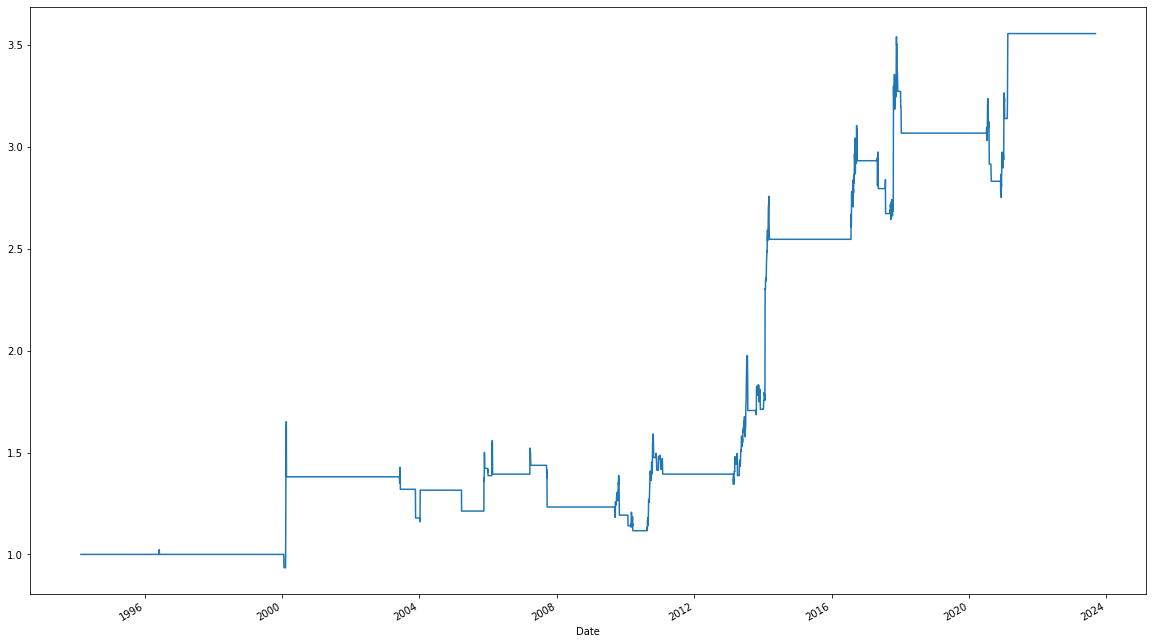

In [173]:
# df[["sReturn", "hReturn"]].plot(figsize=(20,12))
df["sReturn"].plot(figsize=(20,12))

In [214]:
# df[815:835]
# df.loc[(df["pos"] < 1) & (df["Strategy"] == -1), "Strategy"] = 0
# df["1994-01-10":"1994-02-25"]
trade = 2

date1 = (df.index[df['Strategy'] == 1].tolist()[trade] - timedelta(days=5)).strftime("%Y-%m-%d")
date2 = (df.index[df['Strategy'] == -1].tolist()[trade] + timedelta(days=5)).strftime("%Y-%m-%d")
df[date1:date2]
# date2

,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2000-02-02,6.62,7.44,7.19,34600,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.08,0.93,1.37
2000-02-03,7.41,7.75,7.69,29100,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.46
2000-02-04,7.69,8.50,8.25,55800,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.57
2000-02-07,8.44,11.62,11.00,464400,11.62,2000-02-07,1,0.00,3,11.62,0.00,0.29,0.93,2.10
2000-02-08,11.31,12.62,11.88,258400,12.62,2000-02-08,0,1.00,3,12.62,0.08,0.08,1.01,2.26
2000-02-09,13.12,13.12,12.88,97300,13.12,2000-02-09,0,1.00,3,13.12,0.08,0.08,1.09,2.45
2000-02-10,13.00,17.12,16.50,254700,17.12,2000-02-10,0,1.00,3,17.12,0.25,0.25,1.40,3.14
2000-02-11,16.50,18.00,17.62,199400,18.00,2000-02-11,0,1.00,3,18.00,0.07,0.07,1.50,3.36
2000-02-14,18.31,19.25,18.88,130500,19.25,2000-02-14,0,1.00,3,19.25,0.07,0.07,1.60,3.60


In [199]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit   355.62
Hold         507.81
dtype: float64

In [14]:
df["sReturn"].nsmallest(10)

Date
1965-04-15   1.01
1965-04-20   1.02
1965-04-21   1.02
1965-04-22   1.02
1965-04-23   1.02
1965-04-26   1.02
1965-04-27   1.02
1965-04-28   1.02
1965-04-29   1.02
1965-04-30   1.02
Name: sReturn, dtype: float64

# Optimization

In [262]:
for ticker in mult_opt.columns.get_level_values(0).unique():
    print(ticker)
    display(mult_opt[ticker].sort_values("strategy return", ascending=False).head(5))

AAPL


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
15,0,310,9,58.29,70,"1,383.43"
10,0,260,9,57.06,70,"1,383.43"
11,0,270,9,57.06,70,"1,383.43"
12,0,280,9,57.06,70,"1,383.43"
13,0,290,9,57.06,70,"1,383.43"


NVDA


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
12,0,280,9,15.82,57,"1,127.40"
2,0,180,9,15.82,57,"1,127.40"
3,0,190,9,15.82,57,"1,127.40"
4,0,200,9,15.82,57,"1,127.40"
5,0,210,9,15.82,57,"1,127.40"


IBM


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
93,25,290,9,2.73,52,20.23
94,25,300,9,2.73,52,20.23
95,25,310,9,2.73,52,20.23
89,25,250,9,2.59,51,20.23
90,25,260,9,2.59,51,20.23


TSLA


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
11,0,270,9,9.55,24,157.90
14,0,300,9,9.55,24,157.90
12,0,280,9,9.55,24,157.90
13,0,290,9,9.55,24,157.90
15,0,310,9,9.53,24,157.90


GOOG


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
24,5,240,9,2.67,23,54.50
27,5,270,9,2.67,23,54.50
26,5,260,9,2.67,23,54.50
25,5,250,9,2.67,23,54.50
23,5,230,9,2.67,23,54.50


F


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
55,15,230,9,7.37,49,5.55
54,15,220,9,7.37,49,5.55
53,15,210,9,7.37,49,5.55
52,15,200,9,7.37,49,5.55
51,15,190,9,7.37,49,5.55


GM


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
137,40,250,9,0.93,10,0.95
143,40,310,9,0.93,10,0.95
136,40,240,9,0.93,10,0.95
138,40,260,9,0.93,10,0.95
139,40,270,9,0.93,10,0.95


META


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
0,0,160,9,1.85,18,7.81
2,0,180,9,1.85,18,7.81
3,0,190,9,1.85,18,7.81
4,0,200,9,1.85,18,7.81
5,0,210,9,1.85,18,7.81


NFLX


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
104,30,240,9,4.11,37,370.39
107,30,270,9,4.11,37,370.39
111,30,310,9,4.11,37,370.39
110,30,300,9,4.11,37,370.39
109,30,290,9,4.11,37,370.39


In [119]:
mask = mult_opt["ABEO"]["time thresh1"] != 0
mult_opt["ABEO"][mask].sort_values("strategy return", ascending=False).head(20)
# mult_opt["EMO"].sort_values("strategy return", ascending=False).head(20)

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
34,6,280,8,109.18,37,0.00
35,6,280,9,103.82,37,0.00
31,6,260,8,101.30,36,0.00
28,6,240,8,101.30,36,0.00
29,6,240,9,98.51,36,0.00
32,6,260,9,98.51,36,0.00
25,6,220,8,87.84,35,0.00
26,6,220,9,85.42,35,0.00
22,6,200,8,83.45,34,0.00
23,6,200,9,81.15,34,0.00


C:\Users\עידן\AppData\Local\Temp\ipykernel_8108\4201007631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')


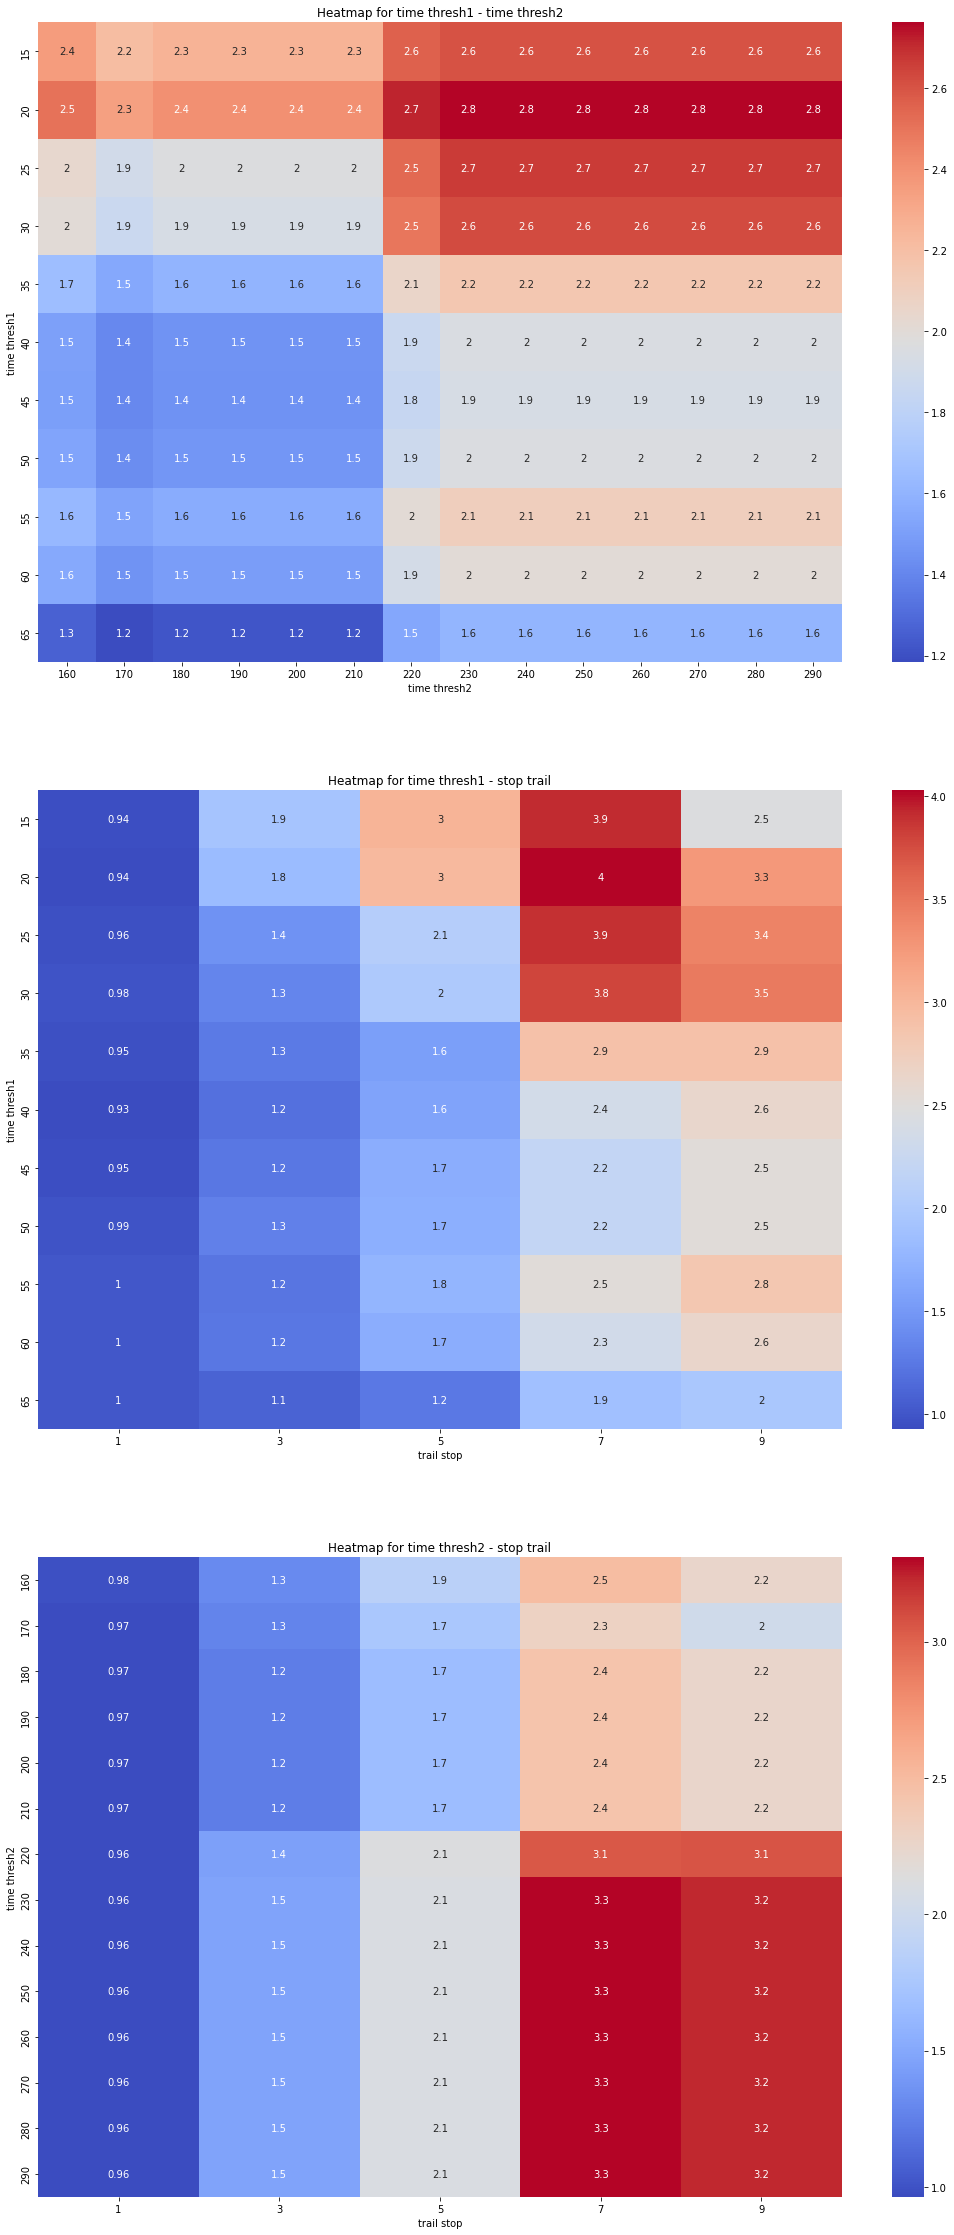

In [253]:
df = mult_opt["NFLX"]
df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')
tt1_tt2 = df.pivot_table(values='return_mean', index='time thresh1', columns='time thresh2')
tt1_ts = df.pivot_table(values='return_mean', index='time thresh1', columns='trail stop')
tt2_ts = df.pivot_table(values='return_mean', index='time thresh2', columns='trail stop')

fig, ax = plt.subplots(3, 1, figsize=(18, 40))

sns.heatmap(tt1_tt2, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Heatmap for time thresh1 - time thresh2')

sns.heatmap(tt1_ts, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Heatmap for time thresh1 - stop trail')

sns.heatmap(tt2_ts, annot=True, cmap='coolwarm', ax=ax[2])
ax[2].set_title('Heatmap for time thresh2 - stop trail')


# plt.tight_layout()
plt.show()

In [140]:
mult_opt.to_csv("multi.csv")

In [238]:
# pd.read_csv("multi.csv", header=[0, 1], index_col=[0]).compare(mult_opt)
# mult_opt
tmp = pd.read_csv("multi.csv", header=[0, 1], index_col=[0])

In [255]:
tmp = mult_opt.copy()


AAPL                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             15          160          9            8.21     44    1,383.43
1             15          170          9            7.88     45    1,383.43
2             15          180          9           10.16     46    1,383.43
3             15          190          9           10.16     46    1,383.43
4             15          200          9           10.16     46    1,383.43
..           ...          ...        ...             ...    ...         ...
149           65          250          9            3.37     18    1,383.43
150           65          260          9            3.37     18    1,383.43
151           65          270          9            3.37     18    1,383.43
152           65          280          9            3.37     18    1,383.43
153           65          290          9            3.37     18    1,383.43

[154 rows x 6 columns]

In [242]:
for tic in tmp.columns.get_level_values(0).unique():
    print(tic)
    display(tmp[tic].sort_values("strategy return", ascending=False).head(1))

AAPL


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
119,50,215,9,13.01,36,"1,383.43"


NVDA


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
1084,78,130,9,5.09,7,"1,127.40"


IBM


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
889,70,235,9,1.90,32,20.23


TSLA


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
944,74,140,9,2.59,5,157.90


GOOG


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
294,54,240,9,2.05,16,54.50


F


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
509,62,155,9,4.27,14,5.55


GM


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
1146,78,195,3,1.25,4,0.95


META


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
1058,78,105,7,1.18,7,7.81


NFLX


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
139,50,235,9,3.57,20,370.39
